## Task

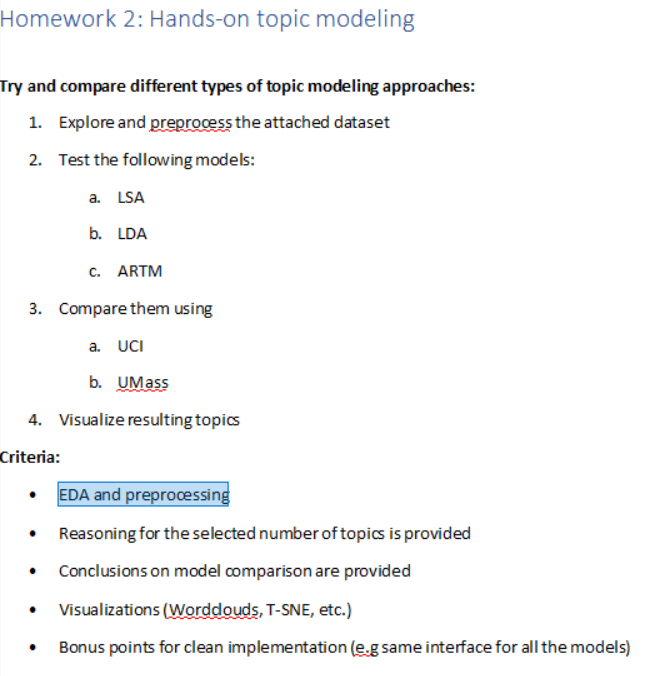

# Installing external libraries

In [ ]:
!pip install gensim

In [ ]:
!pip install pymorphy2

  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13709 sha256=86a0f8166ff5f3f69b25646c81af302c99c3204547b213f5316a4f96c2339183
  Stored in directory: c:\users\irina_trushikhina\appdata\local\pip\cache\wheels\56\ea\58\ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


# Imports

In [ ]:
#basic package
import numpy as np
import pandas as pd
import scipy

#nlp
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
import string
import gensim
from gensim import corpora, models
from gensim.models import LsiModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pymorphy2 import MorphAnalyzer

#feature engineering
from gensim import utils
import gensim.parsing.preprocessing as gsp
from sklearn.feature_extraction.text import TfidfVectorizer

#vizualiazation
from pprint import pprint
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from prettytable import PrettyTable
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider, value, LabelSet, Legend, ColumnDataSource
from bokeh.plotting import figure, show, output_notebook, save

#settings
import os
import gc

# Initiallization

In [ ]:
%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 12

output_notebook()

import warnings 
warnings.filterwarnings('ignore')

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

stopwords=nltk.corpus.stopwords.words('russian')
stopwords.extend(['что', 'это', 'так', 'вот', 'быть',
                   'как', 'на'])
stop_words.extend(stopwords.words('english'))

# для воспроизводимости результатов
seed = 239
np.random.seed(seed)

# Auxilliary functions

In [ ]:
def doubles_and_nans(df, column_name):
    '''
    Функция для чистки текста. 
    Parameters:
    ----------
    df - таблица, над которой будет проводится чистка
    column_name - колонка, над которой будет проводится чистка
    Returns:
    ----------
    df - таблица, в которой убрались дубли и пустые строки
    '''
    doubles = list(df[df[column_name].duplicated() == True].index)
    df = df.drop(doubles, axis='index')
    df.reset_index(drop = True, inplace = True)

    not_str = []

    for i in range(len(df)):
      if type(df[column_name][i]) != str:
        not_str.append(i)
    df = df.drop(not_str, axis='index')
    df.reset_index(drop = True, inplace = True)

    return df

In [ ]:
def text_cleaning(text):
    '''
    Функция для чистки текста. 
    Parameters:
    ----------
    text - текст, над которым производится чистка
    '''
    def strip_html_tags(text):
        '''
        Функция для удаления html tags
        '''
        soup = BeautifulSoup(text, "html.parser")
        stripped_text = soup.get_text(separator=" ")
        return stripped_text

    def remove_URL(text):
        '''
        Функция для удаления url.
        '''
        url = re.compile(r'http(s*)?://\S+|www\.\S+')
        return url.sub(r'',text)

    def remove_emoji(text):
        '''
        Функция для удаления эмоджис и эмотиконов в тексте.
        '''
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    def remove_ip(text):
        '''
        Функция для удаления ip адресов
        '''
        text = re.sub("([0-9]{1,3}[\.]){3}[0-9]{1,3}", "", text)
        return text

    def remove_stopwords(text):
        '''
        Функция для удаления стоп-слов, а также всех не слов и отдельных букв
        text - список слов
        '''
        text = word_tokenize(text)
        text = [token for token in text if ((len(token) >= 3) and (token not in stop_words) and token.isalpha())]
        return text

    def normalization_of_text(text):
        '''
        Функция для нормализации списка
        text - список слов
        '''
        #text = retoken.findall(text)
        text = [morph.parse(x)[0].normal_form for x in text]
        return ' '.join(text)

    filters = [ 
             strip_html_tags,
             remove_URL, 
             remove_emoji,
             remove_ip,
             gsp.strip_numeric, # уберем цифры
             remove_stopwords, 
             normalization_of_text
             ]

    for f in filters:
          text = f(text)
                
    return text

# Downloads

In [ ]:
df = pd.read_csv('posts.csv', sep=',')

# EDA and preprocessing

In [ ]:
df.sample(5)

,id,user,user_link,clean_title,clean_text,clean_tags,clean_hubs,Timestamp
8096,278759,palexisru,https://habr.com/ru/users/palexisru/,идея обучающей игры для школьников,доброго времени чтения уважаемые участник habr...,[],"['программирование', 'разработка_игр']",2016-03-08 11:40:00
11619,438442,fekrado,https://habr.com/ru/users/fekrado/,пересылка запросов от apache на payara server ...,в этой серии статей мы постараемся дать обзор ...,['apache'],"['java', 'apache']",2019-02-01 12:37:00
4293,391283,Whoer_net,https://habr.com/ru/users/Whoer_net/,история одного проекта идея на миллион,не говорите мне что у вас есть идея на миллион...,"['webrtc', 'proxy', 'vpn', 'дизайн']","['дизайн', 'финансы_в_it']",2016-03-02 17:53:00
19704,449886,drWhy,https://habr.com/ru/users/drWhy/,это как на велосипеде кататься,disclaimerданное руководство не претендует на ...,"['обучение', 'велосипед']",['здоровье'],2019-04-28 21:01:00
2013,350426,BubaVV,https://habr.com/ru/users/BubaVV/,разработка игр под nes на c главы 17-21 своя игра,в этой части соберем все вместе и сделаем прос...,"['nes', 'nintendo_entertainment_system', 'cc65...","['ненормальное_программирование', 'assembler',...",2018-03-11 20:32:00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43866 entries, 0 to 43865
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           43866 non-null  int64 
 1   user         43866 non-null  object
 2   user_link    43866 non-null  object
 3   clean_title  43866 non-null  object
 4   clean_text   43861 non-null  object
 5   clean_tags   43866 non-null  object
 6   clean_hubs   43866 non-null  object
 7   Timestamp    43866 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.7+ MB


In [ ]:
df.shape

(43866, 8)

Нам не нужны столбцы id, user, user_link, Timestamp, clean_title. Удалим их

In [ ]:
df = df[['clean_text', 'clean_tags', 'clean_hubs']]
df.head(5)

,clean_text,clean_tags,clean_hubs
0,в следующем году будет 20 лет с момента создан...,"['microsoft', 'облако', 'azure', 'event', 'sec...","['информационная_безопасность', 'системное_адм..."
1,sdk для magic leap уже скорокомпания magic lea...,"['apple', 'magic_leap', 'fluent']","['разработка_мобильных_приложений', 'разработк..."
2,публикуем перевод статьи которую мы нашли на h...,"['программирование', 'парное_программирование'...","['программирование', 'git', 'системы_управлени..."
3,будущее электронной торговли уже здесьпрежде ч...,"['автоматизация_торговли', 'электронная_торгов...","['управление_e-commerce', 'периферия']"
4,в рамках данной статьи мы постарались дать отв...,"['bitcoin', 'privacy', 'bitshares', 'monero']","['информационная_безопасность', 'платежные_сис..."


In [ ]:
df.clean_text[0]

'в следующем году будет 20 лет с момента создания службы каталогов active directory за это время служба обросла функционалом протоколами различными клиентами но необходимость поддерживать совместимость с рядом устаревших клиентов вынуждает иметь настройки по-умолчанию ориентированные на совместимость администраторы часто не меняют их а это создает большой риск в этой статье мы рассмотрим обнаружение атак которые могут привести к domain dominanceчто общего между между атаками на active directory и azure 1 марта 2018 года был выпущен сервис azure advanced threat protection это сервис который является облачным аналогом локального продукта advanced threat analytics в отличии от локальной версии облачная не имеет искусственных ограничений для машинного обучения и обновляется регулярно как и любые облачные сервисы с его помощью можно обнаружить как типовые атаки так и аномальное поведение пользователейдля начала работы можно зарегистрировать пробную подпискупосле первичных настроек потребует

Значит, от знаком препинания уже избавились. И понизили lowercase. Осталось:

1. Из анализируемых документов исключаются стоп-слова. 

2. з анализируемых документов необходимо отфильтровать цифры, отдельные буквы и знаки препинания.

3. Исключить слова, которые встречаются во всех документах только один раз. Это не влияет на конечный результат, но сильно упрощает математические вычисления.

4. Убрать пустые отзывы.

5. Убрать повторяющиеся отзывы

Теперь займемся чисткой текстов. Удалим дубли и пустые строки в столбце clean_text

In [ ]:
df = doubles_and_nans(df, 'clean_text')

In [ ]:
df.shape

(43853, 3)

Проведем чистку

In [ ]:
morph = MorphAnalyzer()

In [ ]:
%%time
df['clean_text'] = df['clean_text'].apply(lambda row: text_cleaning(row))

Wall time: 1h 33min 36s


Попытаемся найти пустые отзывы и дубли еще раз. Они могли появится в ходе чистки

In [ ]:
df = doubles_and_nans(df, 'clean_text')

In [ ]:
df.shape

(43851, 3)

In [ ]:
df.head(5)

,clean_text,clean_tags,clean_hubs
0,следующий год год момент создание служба катал...,"['microsoft', 'облако', 'azure', 'event', 'sec...","['информационная_безопасность', 'системное_адм..."
1,sdk magic leap скорокомпания magic leap волшеб...,"['apple', 'magic_leap', 'fluent']","['разработка_мобильных_приложений', 'разработк..."
2,публиковать перевод статья который наслать hac...,"['программирование', 'парное_программирование'...","['программирование', 'git', 'системы_управлени..."
3,будущее электронный торговля здесьпрежде перех...,"['автоматизация_торговли', 'электронная_торгов...","['управление_e-commerce', 'периферия']"
4,рамка дать статья постараться дать ответ вопро...,"['bitcoin', 'privacy', 'bitshares', 'monero']","['информационная_безопасность', 'платежные_сис..."


In [ ]:
df.to_csv('h2w.prepro_1.csv')